# CausalNet Implementation on a Cancer Prediction Task

## Data Loading

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn.metrics import roc_curve, auc, confusion_matrix
import scikitplot as skplt


data_path = 'cancer_prediction_data.csv'
df = pd.read_csv(data_path)

feature_cols = ['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'PhysicalActivity', 'AlcoholIntake', 'CancerHistory']
target_col = 'Diagnosis'

X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

In [ ]:
from sklearn.model_selection import train_test_split

class CancerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds = CancerDataset(X_train, y_train)
test_ds  = CancerDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

## CausalNet Architecture Definition

In [ ]:
class FeatureEncoder(nn.Module):
    '''
    Simple encoder to transform input features.
    '''
    def __init__(self, input_dims):
        super().__init__()
        self.linear = nn.Linear(input_dims, input_dims)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.linear(x))

class StrictCausalLayer(nn.Module):
    '''
    Strict causal layer that learns a sparse adjacency matrix with a maximum number of parents per node.
    '''
    def __init__(self, dim, max_parents=3):
        super().__init__()
        self.dim = dim
        self.max_parents = max_parents
        self.A = nn.Parameter(torch.randn(dim, dim) * 0.01)
        self.register_buffer('mask', torch.tril(torch.ones(dim, dim), diagonal=-1))
        
    def forward(self, z):
        # Sparsity is applied by selecting the top-k parents for each node.
        A_masked = self.A * self.mask
        A_sparse = torch.zeros_like(A_masked)
        for i in range(self.dim):
            col = A_masked[:, i]
            if col.nonzero().numel() > 0:
                _, top_indices = torch.topk(torch.abs(col), 
                                          min(self.max_parents, col.nonzero().numel()))
                A_sparse[top_indices, i] = col[top_indices]
        
        parent_info = z @ A_sparse
        return z + torch.tanh(parent_info)

class Predictor(nn.Module):
    '''
    Simple feedforward neural network for prediction.
    '''
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim//2)
        self.fc2 = nn.Linear(dim//2, 1)
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h)).squeeze(-1)

class CausalNet(nn.Module):
    '''
    CausalNet definition with strict causal assumptions.
    '''
    def __init__(self, input_dims):
        super().__init__()
        self.encoder = FeatureEncoder(input_dims)
        self.causal_layer = StrictCausalLayer(dim=input_dims)
        self.predictor   = Predictor(dim=input_dims)
    def forward(self, x):
        z = self.encoder(x)
        z_causal = self.causal_layer(z)
        pred = self.predictor(z_causal)
        return pred, z_causal

# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CausalNet(input_dims=len(feature_cols)).to(device)

summary(model, input_size=(64, len(feature_cols)),
        col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
CausalNet                                [64, 8]                   [64]                      --                        --                        --
├─FeatureEncoder: 1-1                    [64, 8]                   [64, 8]                   --                        --                        --
│    └─Linear: 2-1                       [64, 8]                   [64, 8]                   72                        --                        4,608
│    └─ReLU: 2-2                         [64, 8]                   [64, 8]                   --                        --                        --
├─StrictCausalLayer: 1-2                 [64, 8]                   [64, 8]                   64                        --                        --
├─Predictor: 1-3                         [64, 8]                   [64]                      --       

## CausalNet Learning Parameters

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Acyclicity constraint from NOTEARS
def acyclicity_loss(A):
    expm = torch.matrix_exp(A * A)
    return torch.trace(expm) - A.size(0)

def structural_regularization(A, mask):
    A_masked = A * mask
    
    # Encourage sparsity
    sparsity_loss = torch.sum(torch.abs(A_masked))
    
    # Encourage small coefficients
    magnitude_loss = torch.sum(A_masked ** 2)
    
    # Penalize complex structures
    complexity_loss = torch.sum(torch.abs(A_masked) > 0.1)
    
    return sparsity_loss + 0.1 * magnitude_loss + 0.01 * complexity_loss

## CausalNet Training Loop

In [ ]:
n_epochs = 100
l1_lambda = 1e-3
acyclic_lambda = 1.0

train_losses, train_accs = [], []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    correct = total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        pred, _ = model(X_batch)

        # losses
        bce = criterion(pred, y_batch)
        l1 = torch.norm(model.causal_layer.A, 1)
        acyc = acyclicity_loss(model.causal_layer.A * model.causal_layer.mask)
        struct_reg = structural_regularization(model.causal_layer.A, model.causal_layer.mask)
        loss = bce + l1_lambda * l1 + acyclic_lambda * acyc + struct_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        predicted = (pred > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / len(train_ds)
    acc = correct / total

    train_losses.append(avg_loss)
    train_accs.append(acc)

    print(f"Epoch {epoch+1}/{n_epochs} — Loss: {avg_loss:.4f} — Acc: {acc:.4f}")

Epoch 1/100 — Loss: 0.8273 — Acc: 0.5017
Epoch 2/100 — Loss: 0.6602 — Acc: 0.6342
Epoch 3/100 — Loss: 0.6433 — Acc: 0.6400
Epoch 4/100 — Loss: 0.6377 — Acc: 0.6450
Epoch 5/100 — Loss: 0.6330 — Acc: 0.6492
Epoch 6/100 — Loss: 0.6290 — Acc: 0.6558
Epoch 7/100 — Loss: 0.6260 — Acc: 0.6725
Epoch 8/100 — Loss: 0.6224 — Acc: 0.6567
Epoch 9/100 — Loss: 0.6210 — Acc: 0.6750
Epoch 10/100 — Loss: 0.6152 — Acc: 0.6775
Epoch 11/100 — Loss: 0.6113 — Acc: 0.6917
Epoch 12/100 — Loss: 0.6076 — Acc: 0.6950
Epoch 13/100 — Loss: 0.6040 — Acc: 0.6908
Epoch 14/100 — Loss: 0.6007 — Acc: 0.6975
Epoch 15/100 — Loss: 0.5972 — Acc: 0.6900
Epoch 16/100 — Loss: 0.5917 — Acc: 0.7050
Epoch 17/100 — Loss: 0.5887 — Acc: 0.6967
Epoch 18/100 — Loss: 0.5830 — Acc: 0.7108
Epoch 19/100 — Loss: 0.5802 — Acc: 0.7183
Epoch 20/100 — Loss: 0.5749 — Acc: 0.7208
Epoch 21/100 — Loss: 0.5719 — Acc: 0.7233
Epoch 22/100 — Loss: 0.5675 — Acc: 0.7192
Epoch 23/100 — Loss: 0.5619 — Acc: 0.7292
Epoch 24/100 — Loss: 0.5571 — Acc: 0.7325
E

## Model Evaluation

In [6]:
model.eval()
from sklearn.metrics import roc_auc_score, accuracy_score

y_preds, y_trues = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred, _ = model(X_batch)
        y_preds.append(pred.cpu().numpy())
        y_trues.append(y_batch.numpy())

y_preds = np.concatenate(y_preds)
y_trues = np.concatenate(y_trues)
print("Test AUC:", roc_auc_score(y_trues, y_preds))
print("Test Acc:", accuracy_score(y_trues, (y_preds>0.5).astype(int)))

Test AUC: 0.9226949025487257
Test Acc: 0.8466666666666667


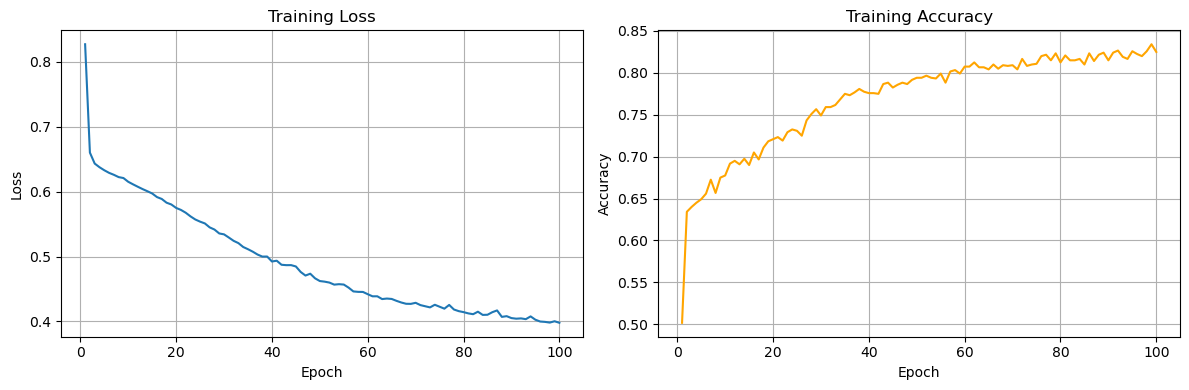

In [7]:
# Plot loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(range(1, n_epochs+1), train_losses, label="Train Loss")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.set_title("Training Loss")
ax1.grid(True)

ax2.plot(range(1, n_epochs+1), train_accs, label="Train Acc", color='orange')
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy"); ax2.set_title("Training Accuracy")
ax2.grid(True)

plt.tight_layout()
plt.show()

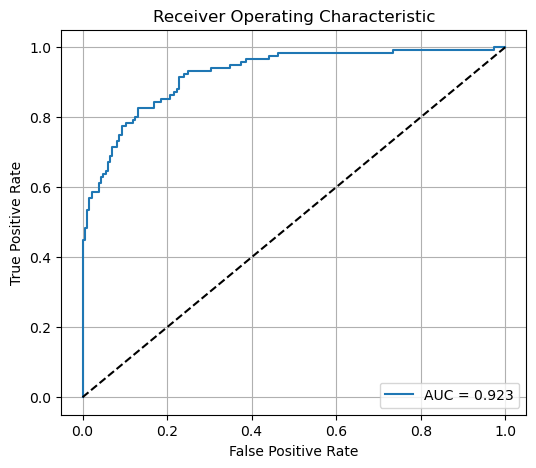

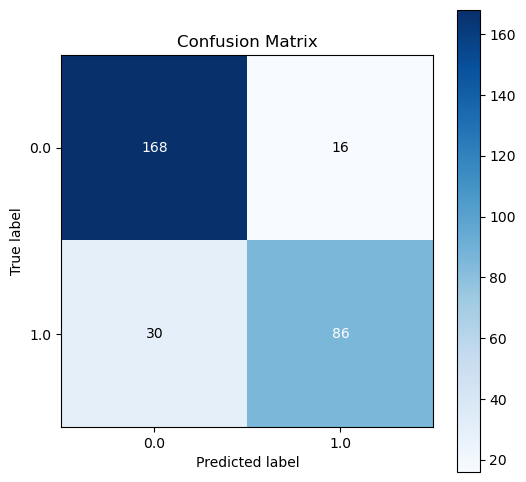

In [8]:
# Compute and plot ROC curve
fpr, tpr, _ = roc_curve(y_trues, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Compute and plot confusion matrix at 0.5 threshold
cm = confusion_matrix(y_trues, (y_preds>0.5).astype(int))
skplt.metrics.plot_confusion_matrix(y_trues, (y_preds>0.5).astype(int),
                                     figsize=(6,6))
plt.title("Confusion Matrix")
plt.show()

## Visualizing the Learned Causal Graph

Dynamic threshold (0th percentile): 0.0000


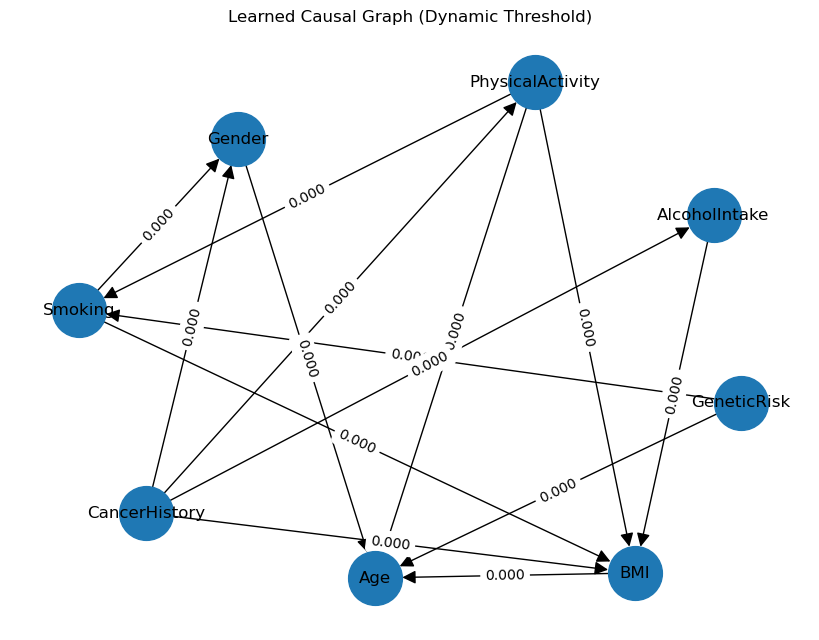

In [ ]:
# Retrieve the learned adjacency matrix
A_learned = (model.causal_layer.A * model.causal_layer.mask).detach().cpu().numpy()

# Compute absolute weight distribution and choose a data-driven threshold
weights = np.abs(A_learned.flatten())
thresh = np.percentile(weights, 0)
print(f"Dynamic threshold (0th percentile): {thresh:.4f}")

# Visualize the learned causal graph
G = nx.DiGraph()
for i, src in enumerate(feature_cols):
    for j, dst in enumerate(feature_cols):
        if A_learned[i, j] > thresh:
            G.add_edge(src, dst, weight=A_learned[i, j])

# Visualize
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, arrowsize=20)
edge_labels = {(u, v): f"{d['weight']:.3f}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Learned Causal Graph (Dynamic Threshold)")
plt.show()

## Performing the Counterfactual Analysis

In [ ]:
def counterfactual(model, x_instance, feature_idx, delta):
    """
    Compute baseline and post-intervention predictions:
    - x_instance: 1D numpy array of raw features
    - feature_idx: index of the latent dimension / feature to intervene on
    - delta: amount to adjust
    Returns (baseline_risk, counterfactual_risk)
    """
    model.eval()
    
    # Convert input to tensor
    x = torch.tensor(x_instance, dtype=torch.float32).unsqueeze(0).to(device)

    # Baseline prediction
    y0, _ = model(x)

    # Encode features to latent z
    z = model.encoder(x)

    # Apply intervention: adjust specified latent dimension
    z_cf = z.clone()
    z_cf[0, feature_idx] += delta

    # Propagate through causal layer and predictor
    z_cf = model.causal_layer(z_cf)
    y_cf = model.predictor(z_cf)

    return y0.item(), y_cf.item()

# Test the counterfactual function
example = X_test[0]
# Intervening on the latent variable at index 2 by -1
baseline, after = counterfactual(model, example, feature_idx=2, delta=-1.0)
print(f"Baseline risk: {baseline:.3f}, After lowering BMI by 1 unit: {after:.3f}")

Baseline risk: 0.928, After lowering BMI by 1 unit: 0.946


In [ ]:
# Run countefactual analysis for each feature on the first test patient
for feature in feature_cols:
    feature_idx = feature_cols.index(feature)
    print(f"Feature: {feature}, Index: {feature_idx}")
    example = X_test[0]
    print(feature_cols)
    print("Example features:", example)

    # Increase variable by 1 unit
    baseline, increased = counterfactual(model, example, feature_idx=feature_idx, delta=+1.0)
    print(f"Baseline risk: {baseline:.3f}, After increasing {feature} by 1: {increased:.3f}")

    # Decrease variable by 1 unit
    baseline, decreased = counterfactual(model, example, feature_idx=feature_idx, delta=-1.0)
    print(f"Baseline risk: {baseline:.3f}, After decreasing {feature} by 1: {decreased:.3f}")

Feature: Age, Index: 0
['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'PhysicalActivity', 'AlcoholIntake', 'CancerHistory']
Example features: [46.         1.        30.193804   0.         1.         7.111218
  2.7708485  1.       ]
Baseline risk: 0.928, After increasing Age by 1: 0.958
Baseline risk: 0.928, After decreasing Age by 1: 0.863
Feature: Gender, Index: 1
['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'PhysicalActivity', 'AlcoholIntake', 'CancerHistory']
Example features: [46.         1.        30.193804   0.         1.         7.111218
  2.7708485  1.       ]
Baseline risk: 0.928, After increasing Gender by 1: 0.951
Baseline risk: 0.928, After decreasing Gender by 1: 0.895
Feature: BMI, Index: 2
['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'PhysicalActivity', 'AlcoholIntake', 'CancerHistory']
Example features: [46.         1.        30.193804   0.         1.         7.111218
  2.7708485  1.       ]
Baseline risk: 0.928, After increasing BMI by 1: 0.903
Baseline